In [17]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
import re
import json
from sklearn.model_selection import train_test_split

# DATASET EXPLORATION AND SPLIT

## Humicroedit and Funlines

In [109]:
data_main = pd.read_csv('data/humicroedit/task_1_all/train.csv')
data_funlines = pd.read_csv('data/humicroedit/task_1_all/train_funlines.csv')
humi = pd.concat([data_main, data_funlines])
humi = humi.drop_duplicates()
humi['len'] = [len(i.split(' ')) for i in humi['original']]
humi.head(2)

,id,original,edit,grades,meanGrade,len
0,14530,France is ‘ hunting down its citizens who joined <Isis/> ’ without trial in Iraq,twins,10000,0.2,15
1,13034,"Pentagon claims 2,000 % increase in Russian trolls after <Syria/> strikes . What does that mean ?",bowling,33110,1.6,17


In [110]:
humi['scaled_mean'] = humi.meanGrade/3

Reviews are judged by variable number of people, and humor is subjective. We want to have some measure of how sure we are in the judgements. Paper notes that each headline had 5 judges.

In [111]:
grades = humi.grades.astype(str).str.split('')
std_list = np.zeros(len(grades))
for i,g in enumerate(grades):
    g = g[1:][:-1]
    g = list(map(int, g))
    std_list[i] = np.std(g)
humi['score_std'] = std_list

Text(0, 0.5, 'Standard deviation')

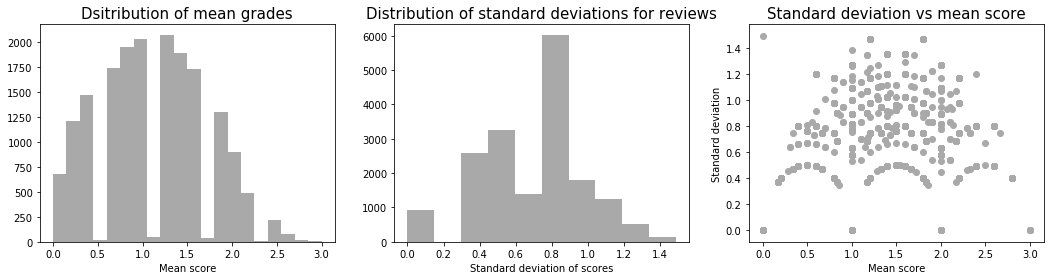

In [112]:
fig, axs = plt.subplots(1, 3, figsize = (18,4))
axs[0].hist(humi.meanGrade, bins=20, color='darkgrey')
axs[0].set_title('Dsitribution of mean grades', size = 15)
axs[0].set_xlabel('Mean score')
axs[1].hist(humi.score_std, color='darkgrey')
axs[1].set_title('Distribution of standard deviations for reviews', size = 15)
axs[1].set_xlabel('Standard deviation of scores')
axs[2].scatter(humi.meanGrade, humi.score_std, color='darkgrey')
axs[2].set_title('Standard deviation vs mean score', size = 15)
axs[2].set_xlabel('Mean score')
axs[2].set_ylabel('Standard deviation')

The most dissagreement is on the "medium funny jokes", in the range from 1 to 2. Let's look at some eaxmples of jokes with 0 scores, jokes in 1-2 range and mean above 2.5

In [234]:
humi[humi.meanGrade==0].head(3)

,id,original,edit,grades,meanGrade,len,score_std
4,6164,Trump was told weeks ago that Flynn misled <Vice/> President .,school,0,0.0,11,0.0
9,14191,Dutch minister resigns in drug baron <row/>,blow,0,0.0,8,0.0
46,11660,Jared Kushner is the Real <President/>,Enemy,0,0.0,7,0.0


In [235]:
humi[humi.meanGrade==1].head(5)

,id,original,edit,grades,meanGrade,len,score_std
2,8731,Iceland PM Calls Snap Vote as Pedophile Furor Crashes <Coalition/>,party,22100,1.0,11,0.894427
7,3731,"As Someone Who Grew Up Among Fundamentalist <Christians/> In The US , I 'm Surprised Anyone 's Surprised About Roy Moore",morons,21110,1.0,21,0.632456
10,14268,Dozens dead in possible gas <attack/> in Syria ; regime denies allegation,bloating,22100,1.0,12,0.894427
12,7614,Trump 's 2nd Nominee for <Army/> Secretary Withdraws,Class,22100,1.0,8,0.894427
21,1415,Russian Trolls Would Love the ' Honest <Ads/> Act ',hotdogs,21110,1.0,10,0.632456


In [236]:
humi[humi.meanGrade==3].head(5)

,id,original,edit,grades,meanGrade,len,score_std
1490,3404,"President Trump 's first year <anniversary/> report card , with grades from A + to F",Kindergarten,33333,3.0,16,0.0
6075,1229,Recent Scandals Highlight Trump 's Chaotic <Management/> Style,Fashion,33333,3.0,8,0.0
419,100419,Stormy Daniels on testifying to Congress : ' I have no fear of being under <oath/> ',politicians,33333,3.0,17,0.0
5115,105115,Sanders Says He Has More <Donors/> Than Trump,hair,33333,3.0,8,0.0


### Are hair jokes more funny? Are Trump jokes more funny?

Text(0.5, 0, 'mean score')

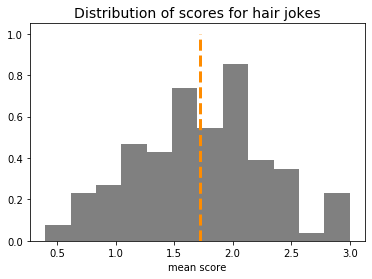

In [244]:
hair = humi[humi.edit.str.lower()=='hair'][['original', 'edit','meanGrade', 'score_std']]
plt.hist(hair.meanGrade, color='grey', bins=12, density=True)
plt.vlines(hair.meanGrade.mean(), ymin=0, ymax=1, color='darkorange', lw=3, ls='--')
plt.title('Distribution of scores for hair jokes', size=14)
plt.xlabel('mean score')

Text(0.5, 0, 'mean score')

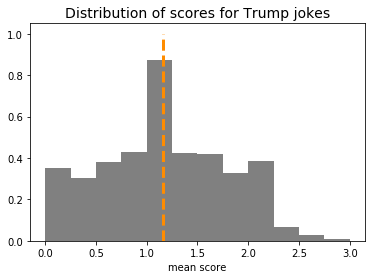

In [241]:
trump = humi[[('trump' in i) for i in humi.original.str.lower()]][['original', 'edit', 'meanGrade', 'score_std']]
plt.hist(trump.meanGrade, color='grey', bins=12, density=True)
plt.vlines(trump.meanGrade.mean(), ymin=0, ymax=1, color='darkorange', lw=3, ls='--')
plt.title('Distribution of scores for Trump jokes', size=14)
plt.xlabel('mean score')

## Prepare data

In [ ]:
"""
Functions for the Humicroedit/Funlines editing
"""
def replace_word(sentence, new_word):
    return re.sub('<(.*?)/>', new_word, sentence)

def drop_replacement_symbols(sentence):
    sentence = sentence.replace('<', '')
    return sentence.replace('/>', '')

def full_processing(row):
    return drop_replacement_symbols(replace_word(row.original, row.edit))

In [120]:
humi['text'] = [full_processing(row) for i,row in humi.iterrows()]
humi['label'] = [int(i>1.5) for i in humi.meanGrade]
original_list = [drop_replacement_symbols(i) for i in humi.original]
humi_jokes = humi[['text', 'meanGrade', 'score_std', 'label']]
humi_orig = pd.DataFrame({
    'text': original_list,
    'meanGrade': np.zeros(len(original_list)),
    'score_std': np.zeros(len(original_list)),
    'label': np.zeros(len(original_list))
})
humi_orig = humi_orig.drop_duplicates()
humi_dataset = pd.concat([humi_jokes, humi_orig], sort=False)
humi_dataset['scaled_mean'] = humi_dataset.meanGrade/3
humi_dataset = humi_dataset.sample(frac=1).reset_index(drop=True) #shuffle
#humi_dataset['text'] = humi_dataset['text'].astype('|S')
humi_dataset.head(3)

,text,meanGrade,score_std,label,scaled_mean
0,"Astros ' Jeff Luhnow , AJ Hinch fired for underwear stealing",1.8,0.4,1.0,0.6
1,France says no idea of Russian hacking Macron,0.6,0.8,0.0,0.2
2,Trump to Call Trade a Key Part of National Security,0.0,0.0,0.0,0.0


In [121]:
humi_dataset.to_csv('data/created_datasets/humi_funlines_all_train_upaired.csv', index=False)

In [141]:
humi_test = pd.read_csv('data/humicroedit/task_1_all/test_truth_task_1.csv')
humi_test = humi_test.drop('id', axis=1)
humi_test['text'] = [full_processing(row) for i,row in humi_test.iterrows()]
humi_test['score'] = humi_test.meanGrade/3
humi_test['label'] = ((humi_test.meanGrade/3)>=0.5).astype(int)
humi_test = humi_test[['text', 'score', 'label']]
humi_test = humi_test.sample(frac=1).reset_index(drop=True) #shuffle
humi_test.head()

,text,score,label
0,We ca n’t let Trump go down Putin ’s rabbithole,0.266667,0
1,"Trump only cares about ' specific books in specific industries , ' says former IMF chief economist",0.066667,0
2,"Trump 's views on gardening ' continue to evolve , ' Secretary of State Rex Tillerson says",0.600000,1
3,Trumping Trump ? New York Governor Andrew Cuomo courts ‘ middle-class privilege ’,0.066667,0
4,Has the Trump presidency permanently changed how the hairs cover the presidency ?,0.400000,0


In [142]:
humi_test.label.value_counts()

0    2479
1    545 
Name: label, dtype: int64

In [143]:
humi_test.to_csv('data/created_datasets/humi_funlines_test_replacements_unpaired.csv', index=False)

# Hashtag wars

In [107]:
hashtag_files_dir = 'data/hashtag_wars/train_dir/train_data/'
hashtag_files = os.listdir(hashtag_files_dir)
for i,f in enumerate(hashtag_files):
    try: 
        temp = pd.read_csv(hashtag_files_dir+f, sep='\t', header=None)
        temp['topic'] = f[:-4]
    except: pass
    if i==0: hashtag = temp
    else: hashtag = pd.concat([hashtag, temp], sort=False)

In [109]:
hashtag.columns = ['id', 'raw_text', 'score', 'topic']
hashtag.head(2)

,id,raw_text,score,topic
0,746395385170649088,Tony Hawk's Pro Mater #RuinAVideoGame @midnight,0,Ruin_A_Video_Game
1,746403973498822658,"@midnight @burnie @GavinFree @bdunkelman ""Silent Hills"" #RuinAVideoGame #FuckYouKonami",0,Ruin_A_Video_Game


In [110]:
#remove mentions and hashtags
hashtag['text'] = [' '.join(word for word in i.split(' ') if not (word.startswith('#') or word.startswith('@'))) for i in hashtag['raw_text']]

In [112]:
hashtag.head(2)

,id,raw_text,score,topic,text
0,746395385170649088,Tony Hawk's Pro Mater #RuinAVideoGame @midnight,0,Ruin_A_Video_Game,Tony Hawk's Pro Mater
1,746403973498822658,"@midnight @burnie @GavinFree @bdunkelman ""Silent Hills"" #RuinAVideoGame #FuckYouKonami",0,Ruin_A_Video_Game,"""Silent Hills"""


In [116]:
hashtag[hashtag.score==2]

,id,raw_text,score,topic,text
111,746183823784878081,@Midnight #PointsMe #RuinAVideoGame Halo by @Adele,2,Ruin_A_Video_Game,Halo by
103,712119303743516673,Voices in head made manifest #TwitterIn5Words @midnight,2,Twitter_In_5_Words,Voices in head made manifest
130,709589126274637825,Hubblegum #ScienceFoods @midnight,2,Science_Foods,Hubblegum
137,667201717956706304,Dat Ash Wednesday #SexyHolidays @midnight,2,Sexy_Holidays,Dat Ash Wednesday
79,653775535429038080,What exactly do you plan to do about joke theft on Twitter? @midnight #BetterDebateQuestions,2,Better_Debate_Questions,What exactly do you plan to do about joke theft on Twitter?
108,750549276737110017,#GotFiredBecause balls deep is not an acceptable answer when asked about my works progress. @midnight,2,Got_Fired_Because,balls deep is not an acceptable answer when asked about my works progress.
98,667576678223212544,"Still don't have kids, mom. @midnight #ThanksgivingIn5Words #PointsMe",2,Thanksgiving_In_5_Words,"Still don't have kids, mom."
18,649791075574530048,Andrew Slice Clay @midnight #Pizzalebrities,2,Pizzalebrities,Andrew Slice Clay
20,664545282881884161,#ScienceABook The Unbearable Lightness of Helium @midnight,2,Science_A_Book,The Unbearable Lightness of Helium
72,743284691390857216,Can't Touch This Thermostat #DadSongs @midnight,2,Dad_Songs,Can't Touch This Thermostat


Might not be very applicable as without topic they are not funny at all

# Crowdtruth

In [19]:
oneliners = pickle.load(open('data/crowdtruth/datasets/humorous_oneliners.pickle', 'rb'))

In [20]:
oneliners_len = [len(i.split(' ')) for i in oneliners]

In [21]:
oneliners[0:10]

['Insanity is hereditary, - You get it from your children.',
 'An honest politician is one who, when bought, stays bought.',
 "You can tune a piano, but you can't tuna fish.",
 'A closed mouth gathers no foot.',
 "What's black and white and red all over?  An embarassed zebra.",
 "What's black and white and red all over?  Certainly not the Halifax newspapers.",
 "Gravity doesn't exist: the earth sucks.",
 "What's the most popular form of birth control?  The headache.",
 "He who laughs last probably doesn't understand the joke.",
 'Let him who takes the plunge remember to return it by Tuesday.']

In [91]:
oneliners_df = pd.DataFrame({
    'text': oneliners,
    'label': np.zeros(len(oneliners))+1
})

In [92]:
train, test = train_test_split(oneliners_df, test_size=0.2)
train.to_csv('data/created_datasets/humorous_oneliners_train.csv', index=False)
test.to_csv('data/created_datasets/humorous_oneliners_test.csv', index=False)

# Short jokes

In [87]:
short = pd.read_csv('data/short_jokes/shortjokes.csv')
short['label'] = np.zeros(short.shape[0])+1
short = short.drop('ID', axis=1)
short.columns = ['text', 'score']
short['len'] = [len(i.split(' ')) for i in short['text']]
short = short[short.len<=100]
short.head()

,text,score,len
0,"[me narrating a documentary about narrators] ""I can't hear what they're saying cuz I'm talking""",1.0,15
1,"Telling my daughter garlic is good for you. Good immune system and keeps pests away.Ticks, mosquitos, vampires... men.",1.0,18
2,I've been going through a really rough period at work this week It's my own fault for swapping my tampax for sand paper.,1.0,23
3,"If I could have dinner with anyone, dead or alive... ...I would choose alive. -B.J. Novak-",1.0,16
4,Two guys walk into a bar. The third guy ducks.,1.0,10


In [88]:
short = short.sample(frac=1).reset_index(drop=True)

In [89]:
train, test = train_test_split(short, test_size=0.2)
train.to_csv('data/created_datasets/shortjokes_train.csv', index=False)
test.to_csv('data/created_datasets/shortjokes_test.csv', index=False)

# Joke dataset

In [179]:
wocka = json.load((open('data/joke_dataset/wocka.json')))
wocka_oneliners = [i['body'] for i in wocka if (i['category']=='One Liners')]
len(wocka_oneliners)

917

In [ ]:
stupid = json.load((open('data/joke_dataset/stupidstuff.json')))
stupid_oneliners_dict = [i for i in stupid if (i['category']=='One Liners')]
len(stupid_oneliners_dict)

Not a very good resource, not enough, and generally low quality

# Puns dataset
From Reddit Humor detection repository

In [100]:
puns.columns

Index(['label', ' text'], dtype='object')

In [107]:
puns = pd.read_csv('data/reddithumordetection/full_datasets/puns/puns_pos_neg_data.csv')
puns.columns = ['label', 'text']
puns = puns.replace(-1, 0)
puns['len'] = [len(i.split(' ')) for i in puns['text']]
puns = puns.sample(frac=1).reset_index(drop=True)
puns.head(3)

,label,text,len
0,1,i just finished reading newton s principia mathematica and found much of it to be rather derivative,17
1,0,But they also pay close attention to issues facing the little town,12
2,0,He said that when he went down to the university s main gate to see why his friends weren t being allowed in a group of Chinese attacked him,29


In [105]:
puns.label.value_counts()

1    2423
0    2403
Name: label, dtype: int64

In [108]:
train, test = train_test_split(puns, test_size=0.2)
train.to_csv('data/created_datasets/puns_train.csv', index=False)
test.to_csv('data/created_datasets/puns_test.csv', index=False)

## Balancing with not-jokes datasets

### Crowdtruth data

In [155]:
proverbs = pickle.load(open('data/crowdtruth/datasets/proverbs.pickle', 'rb'))
proverbs_df = pd.DataFrame({
    'text': proverbs,
    'len': [len(i.split(' ')) for i in proverbs],
    'label': np.zeros(len(proverbs)),
    'source': ['proverbs' for i in range(len(proverbs))]
})
reuters = pickle.load(open('data/crowdtruth/datasets/reuters_headlines.pickle', 'rb'))
reuters_df = pd.DataFrame({
    'text': reuters,
    'len': [len(i.split(' ')) for i in reuters],
    'label': np.zeros(len(reuters)),
    'source': ['reuters' for i in range(len(reuters))]
})
wiki = pickle.load(open('data/crowdtruth/datasets/wiki_sentences.pickle', 'rb'), encoding='latin1')
wiki_df = pd.DataFrame({
    'text': wiki,
    'len': [len(i.split(' ')) for i in wiki],
    'label': np.zeros(len(wiki)),
    'source': ['wiki' for i in range(len(wiki))]
})

In [156]:
all_neg = pd.concat([proverbs_df, reuters_df, wiki_df])
all_neg = all_neg.sample(frac=1).reset_index(drop=True)
all_neg.to_csv('data/created_datasets/neutral_text.csv', index=False)
all_neg.head()

,text,len,label,source
0,China says 'really needs' South China Sea defenses in face of United States:,15,0.0,reuters
1,"They were married on May 29 , 1849 , and together had five children , only two of whom survived to adulthood , two died of typhoid and one of a brain tumor.",33,0.0,wiki
2,Greece says faced with crisis from cutbacks in migrant flows,11,0.0,reuters
3,The Great Gerbil is a large gerbil found throughout much of Central Asia.,13,0.0,wiki
4,"Outside of Europe , he conducted at the Metropolitan Opera in New York as well as the New York Philharmonic Orchestra.",21,0.0,wiki


Could use only sentences shorter than 35 from the Wiki sentences data.

# Dataset options

1. *basic* All together, with binary labels. For Humicroedit use only 'funny' versions. For balance add some news titles and/or quotes

2. *basic-weighted* All together, with added pre-set weights to funny jokes based on the dataset it was taken from. For Humicroedit use only 'funny' versions. For balance add some news titles and/or quotes

3. *humicroedit* Use only humicroedit, only original and replaced

4. *basic expanded* All together, humicroedit both funny and not, shuffled

## BASIC

In [159]:
humi = pd.read_csv('data/created_datasets/humi_funlines_all_train_upaired.csv')[['text', 'label']]
oneliners = pd.read_csv('data/created_datasets/humorous_oneliners_train.csv')[['text', 'label']]
puns = pd.read_csv('data/created_datasets/puns_train.csv')[['text', 'label']]
neutral = pd.read_csv('data/created_datasets/neutral_text.csv')[['text', 'label']]

all_together = pd.concat([humi, oneliners, puns, neutral]).sample(frac=1).reset_index(drop=True)
all_together.to_csv('data/created_datasets/basic_full_dataset_v1.csv')
all_together.head(3)

,text,label
0,Editorial boards of Los Angeles Times and Boston Globe call for Trump 's impeachment,0.0
1,"Public finances show largest January surplus since 2008, retail sales boom:",0.0
2,"Your head is so big, your ears are in different time zones.",1.0


In [160]:
all_together.label.value_counts()

0.0    38032
1.0    10862
Name: label, dtype: int64

In [161]:
train, val = train_test_split(all_together, test_size=0.2)
train.to_csv('data/created_datasets/basic_full_dataset_v1_train.csv', index=False)
val.to_csv('data/created_datasets/basic_full_dataset_v1_validation.csv', index=False)

## BASIC WEIGHTED

In [162]:
humi = pd.read_csv('data/created_datasets/humi_funlines_all_train_upaired.csv')[['text', 'label']]
oneliners = pd.read_csv('data/created_datasets/humorous_oneliners_train.csv')[['text', 'label']]
puns = pd.read_csv('data/created_datasets/puns_train.csv')[['text', 'label']]
neutral = pd.read_csv('data/created_datasets/neutral_text.csv')[['text', 'label']]
short = pd.read_csv('data/created_datasets/shortjokes_train.csv')

In [164]:
short.head(10)

,text,score,len
0,"[wife calls] did you write ""make all the traps from home alone"" on the calendar [me at hardware store holding paint cans and feathers] ""no""",1.0,25
1,I'm gonna start using my cat's ages like y'all do your kids. 5 just projectile vomited and 1 is trying to eat it off the floor.,1.0,26
2,Beltway Holdups,1.0,2
3,"TIL if you say ""gullible"" very slowly it'll come out sounding like ""oranges"". Gotchya!?",1.0,14
4,I don't understand why Taylor Swift has removed all of her music from streaming services You can stream Taylor Swift anytime you want just by turning on the radio,1.0,29
5,Been watching television without eating. I feel like I'm working.,1.0,10
6,"Mom: I HEARD UR SICK Me: just a cold Mom: U HAVE THE ZIKA M: no I- Mom: OH GOD IT'S ZIKA M: mom- Mom: I TRIED TO RAISE U RIGHT M: wait, what",1.0,34
7,"Never gonna invite Jesus for another bondage party Last time around, he forgot his safe word and we had to bury his sorry ass.",1.0,24
8,Guns don't kill people. Fathers with pretty daughters do.,1.0,9
9,Why did the Wise Man get 25 to life? Myrrhder,1.0,10
